In [1]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from src.load_data import dataset
from src.decorator import add_print

In [2]:
# データセットの読み込み
DATASET = dataset()
print(DATASET["fashion-mnist"][1].shape)

c:\Users\human\OneDrive - 埼玉大学\学部4年\04_後期授業\機械学習特論\python\env\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
c:\Users\human\OneDrive - 埼玉大学\学部4年\04_後期授業\機械学習特論\python\env\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(7000, 10)


In [3]:
# MLPのチューニング用関数
def mlp_bulder(hp: kt.HyperParameters) -> tf.keras.Model:
    hp_units = hp.Int("units", min_value=8, max_value=129, step=8)
    hp_layers = hp.Int("layers", min_value=2, max_value=11, step=2)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(hp_layers):
        model.add(tf.keras.layers.Dense(units=hp_units, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
    
    return model

## Fasion-MNIST
### MLP

In [9]:
dataname = "fashion-mnist"
ds_x, ds_y = DATASET[dataname]
train_x, test_x, train_y, test_y = train_test_split(ds_x, ds_y, test_size=0.25, random_state=1)

In [10]:
tf.random.set_seed(42)

# 多層パーセプトロンの学習
mlp_tuner = kt.Hyperband(
    mlp_bulder,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory="C://Users/human/Downloads",
    project_name="fashion_tuner"
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
mlp_tuner.search(train_x, train_y, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 26 Complete [00h 00m 03s]
val_accuracy: 0.8257142901420593

Best val_accuracy So Far: 0.8523809313774109
Total elapsed time: 00h 01m 52s


In [11]:
best_hps = mlp_tuner.get_best_hyperparameters(num_trials=1)[0]

@add_print()
def print_best_hps():
    print("units:", best_hps.get("units"))
    print("layers:", best_hps.get("layers"))
print_best_hps()



units: 96
layers: 4




#### チューニング結果からモデルを作成

In [12]:
# ベストエポックを保存
checkpoint_filepath = "C://Users/human/Downloads/fashion_checkpoint"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

best_mlp_model = mlp_tuner.hypermodel.build(best_hps)
mlp_history = best_mlp_model.fit(train_x, train_y, epochs=50, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/50
132/132 [==============================] - ETA: 0s - loss: 0.9974 - accuracy: 0.6410INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


132/132 [==============================] - 2s 8ms/step - loss: 0.9974 - accuracy: 0.6410 - val_loss: 0.7228 - val_accuracy: 0.7476
Epoch 2/50
111/132 [========================>.....] - ETA: 0s - loss: 0.6157 - accuracy: 0.7717INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


132/132 [==============================] - 1s 6ms/step - loss: 0.5988 - accuracy: 0.7783 - val_loss: 0.5911 - val_accuracy: 0.7867
Epoch 3/50
110/132 [========================>.....] - ETA: 0s - loss: 0.5162 - accuracy: 0.8119INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


132/132 [==============================] - 1s 7ms/step - loss: 0.5094 - accuracy: 0.8169 - val_loss: 0.5712 - val_accuracy: 0.7924
Epoch 4/50
126/132 [===========================>..] - ETA: 0s - loss: 0.4614 - accuracy: 0.8316INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


132/132 [==============================] - 1s 6ms/step - loss: 0.4604 - accuracy: 0.8310 - val_loss: 0.5378 - val_accuracy: 0.8210
Epoch 5/50
132/132 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.8357 - val_loss: 0.5169 - val_accuracy: 0.8076
Epoch 6/50
132/132 [==============================] - 0s 2ms/step - loss: 0.4070 - accuracy: 0.8460 - val_loss: 0.5712 - val_accuracy: 0.8124
Epoch 7/50
112/132 [========================>.....] - ETA: 0s - loss: 0.3787 - accuracy: 0.8627INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


132/132 [==============================] - 1s 7ms/step - loss: 0.3692 - accuracy: 0.8648 - val_loss: 0.5376 - val_accuracy: 0.8219
Epoch 8/50
110/132 [========================>.....] - ETA: 0s - loss: 0.3537 - accuracy: 0.8670INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


132/132 [==============================] - 1s 6ms/step - loss: 0.3542 - accuracy: 0.8679 - val_loss: 0.5038 - val_accuracy: 0.8400
Epoch 9/50
132/132 [==============================] - 0s 2ms/step - loss: 0.3256 - accuracy: 0.8798 - val_loss: 0.4865 - val_accuracy: 0.8352
Epoch 10/50
132/132 [==============================] - 0s 2ms/step - loss: 0.3163 - accuracy: 0.8845 - val_loss: 0.5112 - val_accuracy: 0.8333
Epoch 11/50
126/132 [===========================>..] - ETA: 0s - loss: 0.3102 - accuracy: 0.8849INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


132/132 [==============================] - 1s 6ms/step - loss: 0.3106 - accuracy: 0.8838 - val_loss: 0.5149 - val_accuracy: 0.8495
Epoch 12/50
132/132 [==============================] - 0s 2ms/step - loss: 0.2949 - accuracy: 0.8936 - val_loss: 0.4887 - val_accuracy: 0.8410
Epoch 13/50
132/132 [==============================] - 0s 2ms/step - loss: 0.2602 - accuracy: 0.9048 - val_loss: 0.4942 - val_accuracy: 0.8352
Epoch 14/50
119/132 [==========================>...] - ETA: 0s - loss: 0.2474 - accuracy: 0.9110INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


INFO:tensorflow:Assets written to: C://Users/human/Downloads\checkpoint/assets


132/132 [==============================] - 1s 6ms/step - loss: 0.2459 - accuracy: 0.9110 - val_loss: 0.4924 - val_accuracy: 0.8590
Epoch 15/50
132/132 [==============================] - 0s 2ms/step - loss: 0.2518 - accuracy: 0.9083 - val_loss: 0.4860 - val_accuracy: 0.8467
Epoch 16/50
132/132 [==============================] - 0s 3ms/step - loss: 0.2310 - accuracy: 0.9169 - val_loss: 0.5791 - val_accuracy: 0.8276
Epoch 17/50
132/132 [==============================] - 0s 2ms/step - loss: 0.2273 - accuracy: 0.9138 - val_loss: 0.5229 - val_accuracy: 0.8505
Epoch 18/50
132/132 [==============================] - 0s 2ms/step - loss: 0.2197 - accuracy: 0.9186 - val_loss: 0.5349 - val_accuracy: 0.8495
Epoch 19/50
132/132 [==============================] - 0s 2ms/step - loss: 0.1905 - accuracy: 0.9255 - val_loss: 0.6004 - val_accuracy: 0.8295
Epoch 20/50
132/132 [==============================] - 0s 2ms/step - loss: 0.1986 - accuracy: 0.9281 - val_loss: 0.6189 - val_accuracy: 0.8114
Epoch 21/50

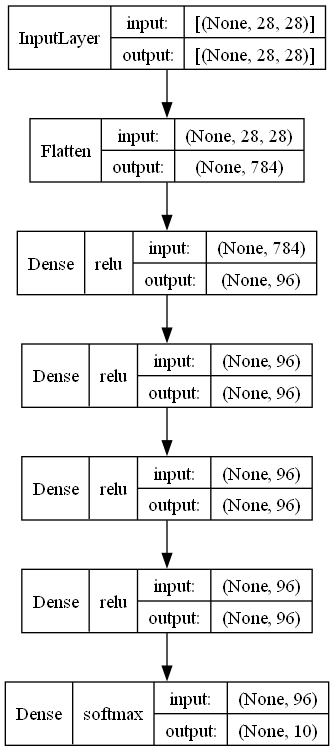

In [14]:
# モデルを描画
tf.keras.utils.plot_model(
    best_mlp_model, 
    show_shapes=True, 
    show_layer_names=False, 
    show_layer_activations=True
)

In [15]:
best_epoch_model = tf.keras.models.load_model(checkpoint_filepath)
best_epoch_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 96)                75360     
                                                                 
 dense_4 (Dense)             (None, 96)                9312      
                                                                 
 dense_5 (Dense)             (None, 96)                9312      
                                                                 
 dense_6 (Dense)             (None, 96)                9312      
                                                                 
 dense_7 (Dense)             (None, 10)                970       
                                                                 
Total params: 104266 (407.29 KB)
Trainable params: 104

In [23]:
pred_y = best_epoch_model.predict(test_x)
pred_y = np.round(pred_y).astype(int)

@add_print("~", 20)
def print_accuracy():
    print("Test accuracy:", accuracy_score(pred_y, test_y))
print_accuracy()

55/55 [==============================] - 0s 2ms/step

~~~~~~~~~~~~~~~~~~~~

Test accuracy: 0.84

~~~~~~~~~~~~~~~~~~~~

